In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re 
from utils import * 
import itertools 
from tqdm import tqdm 
import warnings 
import subprocess
import os 
from src.ggkbase import * 
import glob
import matplotlib as mpl 
%load_ext autoreload
%autoreload 2

# NOTE: The MAG annotations in the metadata might be wrong... 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
dpann_phyla = ['Diapherotrites', 'Parvarchaeota', 'Aenigmarchaeota', 'Nanoarchaeota', 'Nanohaloarchaeota', 'Woesearchaeota', 'Pacearchaeota', 'Micrarchaeota', 'Altiarchaeota', 'Huberarchaeota', 'Undinarchaeota', 'Iainarchaeota']

levels = ['phylum', 'genus', 'class', 'order', 'species', 'domain', 'family']
level_funcs = dict(list(zip(levels, [get_phylum, get_genus, get_class, get_order, get_species, get_domain, get_family])))

In [16]:
# How many total spacers do we have?
genome_id_pattern = r'SR-VP_\d{2}_\d{2}_\d{4}_(ck|N)_(top|bottom|middle)([\.|_])(vamb|metabat2|maxbin2|concoct)([\.|_])(\d+)(_sub)*'
get_genome_id = lambda string : re.search(genome_id_pattern, string).group(0).replace('.', '_')

def fasta_count_sequences(path:str):
    cmd = f'cat {path} | grep -o ">" | wc -l'
    result = subprocess.run(cmd, shell=True, check=True, capture_output=True, text=True)
    return int(result.stdout)

n = sum([fasta_count_sequences(path) for path in glob.glob('../data/spacers/near_cas/*')])
print('Num. sequences in FASTA files:', n)

Num. sequences in FASTA files: 2043


In [18]:
# Time to take a look at the CRISPR spacers! Specifically, looking for hits to the DPANN Archaea within the CRISPR spacers. 
# Perhaps make a target database out of the DPANN Archaea.  

metadata_df = load_metadata()
for level, level_func in level_funcs.items():
    metadata_df[level] = metadata_df.taxonomy.apply(level_func)
metadata_df['dpann'] = metadata_df.phylum.isin(dpann_phyla)

dpann_genome_ids = metadata_df[metadata_df.dpann].index.str.replace('.', '_', regex=False)
dpann_genome_ids = np.unique(dpann_genome_ids)
print('Num. DPANN genomes:', len(dpann_genome_ids))

Num. DPANN genomes: 30


In [19]:
# Want to make a BLAST database of the DPANN genomes for a target database. 
def make_dpann_blast_database(database_path='../data/blast/databases/dpann', dpann_genome_ids=dpann_genome_ids):

    # Clear the file if it already exists. 
    subprocess.run(f'> {database_path}.fn', shell=True, check=True)

    for path in glob.glob('../data/genomes/*'):
        genome_id = os.path.basename(path).replace('.fn', '')
        if genome_id in dpann_genome_ids: # Concatenate all DPANN genomes into a single FASTA file. 
            subprocess.run(f'cat {path} >> {database_path}.fn', shell=True, check=True)

    # The parse_seqids option basically gets rid of the FASTA description. 
    subprocess.run(f'makeblastdb -in {database_path}.fn -out {database_path} -dbtype nucl -parse_seqids', shell=True, check=True)

# make_dpann_blast_database()
        

In [20]:
output_dir = '../data/blast/output'
query_extension = '.fa'
database_path = '../data/blast/databases/dpann'
for query_path in tqdm(glob.glob('../data/spacers/orphan/*'), desc='Searching BLAST target database for spacer hits...'):
    output_path = os.path.join(output_dir, os.path.basename(query_path).replace(query_extension, '.tsv')) 
    if not os.path.exists(output_path):
        subprocess.run(f'cctk spacerblast -o {output_path} -d {database_path} -s {query_path}', shell=True, check=True)

Searching BLAST target database for spacer hits...:   0%|          | 0/182 [00:00<?, ?it/s]ERROR running blast on ../data/blast/databases/dpann:
Searching BLAST target database for spacer hits...: 100%|██████████| 182/182 [00:02<00:00, 80.74it/s]


In [21]:
blast_df = list()
for path in glob.glob(os.path.join(output_dir, '*')):
    has_cas = not 'orphan' in path
    blast_df.append(pd.read_csv(path, sep=r'\s+').assign(query_path=path, has_cas=has_cas))
blast_df = pd.concat(blast_df)
blast_df.columns = blast_df.columns.str.lower()
# blast_df['query_genome_id'] = blast_df.spacer_id.str.replace(r'_\d+:\d+', '', regex=True).map(scaffold_to_bin_map)
blast_df['query_genome_id'] = blast_df.query_path.apply(get_genome_id)
blast_df['target_genome_id'] = blast_df.target_contig.map(scaffold_to_bin_map).apply(get_genome_id)


In [22]:
blast_df = blast_df[blast_df.percent_identity > 80].copy()
metadata_df = metadata_df[~metadata_df.index.duplicated()].copy()
metadata_df.index = metadata_df.index.str.replace('.', '_', regex=False)

for col in list(level_funcs.keys()) + ['dpann']:
    blast_df[f'target_{col}'] = blast_df.target_genome_id.map(metadata_df[col])
    blast_df[f'query_{col}'] = blast_df.query_genome_id.map(metadata_df[col])

In [23]:
# The BLAST query sequences are the predicted spacer, and the targets are things with matches. 
# There are some cases of a detected spacer being identified on the same scaffold, which I think means that the 
# BLAST target database just contains the sequence on which the spacer was predicted. 

scaffold_id_pattern = r'SR-VP_\d{2}_\d{2}_\d{4}_(ck|N)_(top|bottom|middle)_scaffold_\d+'
get_scaffold_id = lambda string : re.search(scaffold_id_pattern, string).group(0).replace('.', '_')
get_scaffold_id('SR-VP_05_06_2024_ck_bottom_scaffold_395')

blast_df['query_contig'] = blast_df.spacer_id.apply(get_scaffold_id)

print('Num. meaningless BLAST hits:', (blast_df.query_contig == blast_df.target_contig).sum())
print('Num. hits with a Cas:', blast_df.has_cas.sum())
print('Num. hits to an orphan spacer:', (~blast_df.has_cas).sum())

# The BLAST query sequences are the predicted spacer, and the targets are things with matches. 
blast_df = blast_df[blast_df.target_contig != blast_df.query_contig].copy()
print('Num. hits to other potential DPANN:', blast_df.query_dpann.sum())

Num. meaningless BLAST hits: 130
Num. hits with a Cas: 176
Num. hits to an orphan spacer: 919
Num. hits to other potential DPANN: 1


In [32]:
blast_df[blast_df.spacer_id.str.contains('1847_2:4')]

,spacer_id,target_contig,protospacer_start,protospacer_end,percent_identity,mismatches,protospacer_sequence,mismatch_locations,target_strand,query_path,...,query_order,target_species,query_species,target_domain,query_domain,target_family,query_family,target_dpann,query_dpann,query_contig
1828,SR-VP_05_06_2024_N_top_scaffold_1847_2:4,SR-VP_05_06_2024_N_middle_scaffold_11254,2707,2740,97.058824,1,ATAATTTATTACGATTACTGACTGACATATCAGG,ATAATTTATTACGATTACTGACTGA.ATATCAGG,minus,../data/blast/output/SR-VP_05_06_2024_N_top.ma...,...,Methanosarcinales,none,none,Archaea,Archaea,UBA9642,Methanoperedenaceae,True,False,SR-VP_05_06_2024_N_top_scaffold_1847


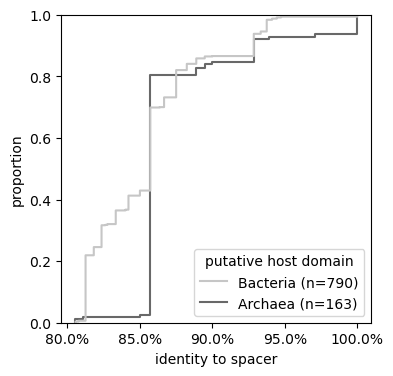

In [24]:
has_cas = False

fig, ax = plt.subplots(figsize=(4, 4))

figure_df = blast_df.copy()
figure_df = figure_df[figure_df.query_domain != 'none'].copy()
if has_cas:
    figure_df = figure_df[figure_df.has_cas].copy()

sns.ecdfplot(figure_df, x='percent_identity', hue='query_domain', palette='Grays')

legend = ax.get_legend()
handles = legend.get_lines()
labels = [label.get_text() for label in legend.get_texts()][:2]
# labels = [f'{domain} (n={(figure_df.query_domain == domain).sum()})' for domain in labels]
labels = [f'{domain} (n={(figure_df.query_domain == domain).sum()})' for domain in labels]
ax.legend(handles, labels, title='putative host domain')

ax.set_ylabel('proportion')
ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter())
ax.set_xlabel('identity to spacer')

plt.show()

In [25]:
level = 'genus'

mask = (blast_df[f'query_{level}'] != 'none') & (blast_df[f'target_{level}'] != 'none')
df = blast_df[(blast_df.query_domain == 'Archaea') & mask]
print('Num. predicted relationships with taxonomy:', len(df))
df.to_csv('/home/prichter/Downloads/spacerblast_results.csv')
pd.crosstab(df[f'query_{level}'], df[f'target_{level}'])

# Is a member of ANME bacteria, it seems. 

Num. predicted relationships with taxonomy: 130


target_genus,ASMP01,CAIVOO01,CAIXYX01,JAGVZE01,JAJYUY01,UBA10161,UBA10205,UBA9642
query_genus,,,,,,,,
CAIXYX01,0,0,1,0,0,0,0,0
JACTUA01,7,6,16,4,4,69,10,2
Methanoperedens,0,0,0,0,0,0,0,10
Nitrosotalea,0,0,0,0,0,0,0,1


In [26]:
blast_df.query_domain.value_counts()

query_domain
Bacteria    790
Archaea     163
none          2
Name: count, dtype: int64

In [27]:
blast_df.to_csv('../data/')

IsADirectoryError: [Errno 21] Is a directory: '../data/'